In [112]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch

    
from typing import List



if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings and Dataset

In [2]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 9912422/9912422 [00:00<00:00, 26862397.26it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




100%|██████████| 1648877/1648877 [00:00<00:00, 9804198.46it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


## MLP

In [3]:
##########################
### MODEL
##########################

# Hyperparameters
random_seed   = 123
learning_rate = 0.005
num_epochs    = 2

# Architecture
num_features = 784
num_hidden_1 = 128
num_hidden_2 = 256
num_classes  = 10


class MultilayerPerceptron(nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(num_features, num_hidden_1),
            nn.ReLU(),
            nn.Linear(num_hidden_1, num_hidden_2),
            nn.ReLU(),
            nn.Linear(num_hidden_2, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


torch.manual_seed(random_seed)
model_pretrained = MultilayerPerceptron(
    num_features=num_features,
    num_hidden_1=num_hidden_1,
    num_hidden_2=num_hidden_2, 
    num_classes=num_classes
)

model_pretrained.to(DEVICE)
optimizer_pretrained = torch.optim.Adam(model_pretrained.parameters(), lr=learning_rate)

In [4]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100


def train(num_epochs, model, optimizer, train_loader, device):

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)

            # FORWARD AND BACK PROP
            logits = model(features)
            loss = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            if not batch_idx % 400:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
                  epoch+1, num_epochs,
                  compute_accuracy(model, train_loader, device)))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [5]:
train(num_epochs, model_pretrained, optimizer_pretrained, train_loader, DEVICE)
print(f'Test accuracy: {compute_accuracy(model_pretrained, test_loader, DEVICE):.2f}%')

Epoch: 001/002 | Batch 000/938 | Loss: 2.2971
Epoch: 001/002 | Batch 400/938 | Loss: 0.2258
Epoch: 001/002 | Batch 800/938 | Loss: 0.0942
Epoch: 001/002 training accuracy: 95.52%
Time elapsed: 0.36 min
Epoch: 002/002 | Batch 000/938 | Loss: 0.0736
Epoch: 002/002 | Batch 400/938 | Loss: 0.0567
Epoch: 002/002 | Batch 800/938 | Loss: 0.0959
Epoch: 002/002 training accuracy: 97.51%
Time elapsed: 0.45 min
Total Training Time: 0.45 min
Test accuracy: 96.72%


## LoRA and DoRA

In [7]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

    
# This LoRA code is equivalent to LinearWithLoRA
class LinearWithLoRAMerged(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        lora = self.lora.A @ self.lora.B
        combined_weight = self.linear.weight + self.lora.alpha*lora.T
        return F.linear(x, combined_weight, self.linear.bias)

    
# This DoRA code is equivalent to LinearWithDoRA
# Code inspired by https://github.com/catid/dora/blob/main/dora.py
class LinearWithDoRAMerged(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )
        
        self.m = nn.Parameter(
            self.linear.weight.norm(p=2, dim=0, keepdim=True))

    def forward(self, x):
        lora = self.lora.A @ self.lora.B
        numerator = self.linear.weight + self.lora.alpha*lora.T
        denominator = numerator.norm(p=2, dim=0, keepdim=True)
        directional_component = numerator / denominator
        new_weight = self.m * directional_component
        return F.linear(x, new_weight, self.linear.bias)

In [8]:
import copy

model_lora = copy.deepcopy(model_pretrained)
model_dora = copy.deepcopy(model_pretrained)

In [9]:
model_lora.layers[0] = LinearWithLoRAMerged(model_lora.layers[0], rank=4, alpha=8)
model_lora.layers[2] = LinearWithLoRAMerged(model_lora.layers[2], rank=4, alpha=8)
model_lora.layers[4] = LinearWithLoRAMerged(model_lora.layers[4], rank=4, alpha=8)

model_lora.to(DEVICE)
optimizer_lora = torch.optim.Adam(model_lora.parameters(), lr=learning_rate)
model_lora

MultilayerPerceptron(
  (layers): Sequential(
    (0): LinearWithLoRAMerged(
      (linear): Linear(in_features=784, out_features=128, bias=True)
      (lora): LoRALayer()
    )
    (1): ReLU()
    (2): LinearWithLoRAMerged(
      (linear): Linear(in_features=128, out_features=256, bias=True)
      (lora): LoRALayer()
    )
    (3): ReLU()
    (4): LinearWithLoRAMerged(
      (linear): Linear(in_features=256, out_features=10, bias=True)
      (lora): LoRALayer()
    )
  )
)

In [10]:
print(f'Test accuracy orig model: {compute_accuracy(model_pretrained, test_loader, DEVICE):.2f}%')
print(f'Test accuracy LoRA model: {compute_accuracy(model_lora, test_loader, DEVICE):.2f}%')

Test accuracy orig model: 96.72%
Test accuracy LoRA model: 96.72%


## Train model with LoRA

In [12]:
def freeze_linear_layers(model):
    for child in model.children():
        if isinstance(child, nn.Linear):
            for param in child.parameters():
                param.requires_grad = False
        else:
            # Recursively freeze linear layers in children modules
            freeze_linear_layers(child)

In [13]:
freeze_linear_layers(model_lora)

# Check if linear layers are frozen
for name, param in model_lora.named_parameters():
    print(f"{name}: {param.requires_grad}")

layers.0.linear.weight: False
layers.0.linear.bias: False
layers.0.lora.A: True
layers.0.lora.B: True
layers.2.linear.weight: False
layers.2.linear.bias: False
layers.2.lora.A: True
layers.2.lora.B: True
layers.4.linear.weight: False
layers.4.linear.bias: False
layers.4.lora.A: True
layers.4.lora.B: True


In [14]:
optimizer_lora = torch.optim.Adam(model_lora.parameters(), lr=learning_rate)
train(num_epochs, model_lora, optimizer_lora, train_loader, DEVICE)
print(f'Test accuracy LoRA finetune: {compute_accuracy(model_lora, test_loader, DEVICE):.2f}%')

Epoch: 001/002 | Batch 000/938 | Loss: 0.1042
Epoch: 001/002 | Batch 400/938 | Loss: 0.0231
Epoch: 001/002 | Batch 800/938 | Loss: 0.1371
Epoch: 001/002 training accuracy: 97.40%
Time elapsed: 0.13 min
Epoch: 002/002 | Batch 000/938 | Loss: 0.2409
Epoch: 002/002 | Batch 400/938 | Loss: 0.1279
Epoch: 002/002 | Batch 800/938 | Loss: 0.0649
Epoch: 002/002 training accuracy: 97.96%
Time elapsed: 0.22 min
Total Training Time: 0.22 min
Test accuracy LoRA finetune: 97.15%


## Pruning

In [174]:
def calculate_distance(model_lora, layer_idx, type_distance='l1'):
    Wo = model_lora.layers[layer_idx].linear.weight
    lora = model_lora.layers[layer_idx].lora.A @ model_lora.layers[layer_idx].lora.B
    combined_weight = Wo + model_lora.layers[0].lora.alpha*lora.T
    
    if type_distance == 'l1':
        return torch.sum(torch.abs(Wo - combined_weight), dim=1)
    elif type_distance == 'l2':
        return torch.sqrt(torch.sum((Wo - combined_weight)**2, dim=1))
    elif type_distance == 'cosine':
        Wo_norm = Wo / Wo.norm(p=2, dim=1, keepdim=True)
        combined_weight_norm = combined_weight / combined_weight.norm(p=2, dim=1, keepdim=True)
        return 1 - torch.sum(Wo_norm * combined_weight_norm, dim=1)
    else:
        raise ValueError(f"Unknown distance type: {type_distance}, only 'l1', 'l2', and 'cosine' are supported")
    
def get_mask(distance, threshold):
    number2delete = int(len(distance) * (threshold / 100))
    _, mask = torch.topk(distance, number2delete, largest=False)
    return mask

def remove_neurons_from_layer(layer, neurons_to_remove):
    new_weights = torch.cat([layer.weight.data[i:i+1] for i in range(layer.weight.data.size(0)) if i not in neurons_to_remove])
    new_bias = torch.cat([layer.bias.data[i:i+1] for i in range(layer.bias.data.size(0)) if i not in neurons_to_remove])
    return nn.Linear(new_weights.size(1), new_weights.size(0)), new_weights, new_bias

def adjust_next_layer(layer, neurons_to_remove_from_previous_layer):
    new_weights = torch.cat([layer.weight.data[:, i:i+1] for i in range(layer.weight.data.size(1)) if i not in neurons_to_remove_from_previous_layer], 1)
    return nn.Linear(new_weights.size(1), new_weights.size(0)), new_weights

def prune(model: nn.Module, masks: List[torch.Tensor]) -> nn.Module:
    
    #assert len(masks) == len(model.layers) // 2, "Number of masks must be equal to the number of linear layers in the model"
    
    model_for_pruning = copy.deepcopy(model)

    # Aplicar la poda y ajustar las capas
    index_layers = 0
    for _, mask in enumerate(masks):
        if mask is not None:
            current_layer = model_for_pruning.layers[index_layers]
            next_layer_idx = index_layers+2

            new_layer, new_weights, new_biases = remove_neurons_from_layer(current_layer, mask)
            model_for_pruning.layers[index_layers] = new_layer
            model_for_pruning.layers[index_layers].weight.data = new_weights
            model_for_pruning.layers[index_layers].bias.data = new_biases

            # Ajustar la siguiente capa si existe
            if next_layer_idx < len(model_for_pruning.layers):
                next_layer = model_for_pruning.layers[next_layer_idx]
                new_layer, new_weights = adjust_next_layer(next_layer, mask)
                model_for_pruning.layers[next_layer_idx] = new_layer
                model_for_pruning.layers[next_layer_idx].weight.data = new_weights
                
        index_layers += 2

    return model_for_pruning    


In [175]:
def get_model_pruned(layers: List[int], model = model_pretrained, type_distance='l1', threshold=50, verbose=False):
    
    masks = [None, None, None]
    for layer in layers:
        vector_of_dist = calculate_distance(model_lora, layer, type_distance)
        mask = get_mask(vector_of_dist, threshold)
        if layer == 0:
            masks[0] = mask
        elif layer == 2:
            masks[1] = mask
        elif layer == 4:
            masks[2] = mask
    
    model_pruned = prune(model, masks)
    model_pruned.to(DEVICE)
    
    if verbose:
        print(model_pruned)
    
    return model_pruned

In [176]:
from tqdm import tqdm

def get_list_of_performance_by_reduction(layers: List[int], type_distance='l1', thresholds=range(0, 101, 10)):
    
    list_of_performance = []
    for threshold in tqdm(thresholds, desc="Thresholds"):
        model_pruned = get_model_pruned(layers, type_distance=type_distance, threshold=threshold)
        accuracy = compute_accuracy(model_pruned, test_loader, DEVICE).item()
        list_of_performance.append(accuracy)
        
    return list_of_performance

In [177]:
import matplotlib.pyplot as plt

def plot_experiment(ths, perf, title):
    plt.plot(ths, perf, marker='o')
    plt.title(title)
    plt.xlabel('Reduction (%)')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()

def experiment(type_distance='l1', ths = range(0, 99, 5)):
    
    layer = [0]
    perf = get_list_of_performance_by_reduction(layer, type_distance=type_distance, thresholds=ths)
    plot_experiment(ths, perf, f"Layer {layer[0]}")
    
    layer = [2]
    ths = range(0, 99, 5)
    perf = get_list_of_performance_by_reduction(layer, type_distance=type_distance, thresholds=ths)
    plot_experiment(ths, perf, f"Layer {layer[0]}")
    
    layer = [0,2]
    ths = range(0, 99, 5)
    perf = get_list_of_performance_by_reduction(layer, type_distance=type_distance, thresholds=ths)
    plot_experiment(ths, perf, f"Layers {layer[0]} and {layer[1]}")
    
    

Thresholds: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


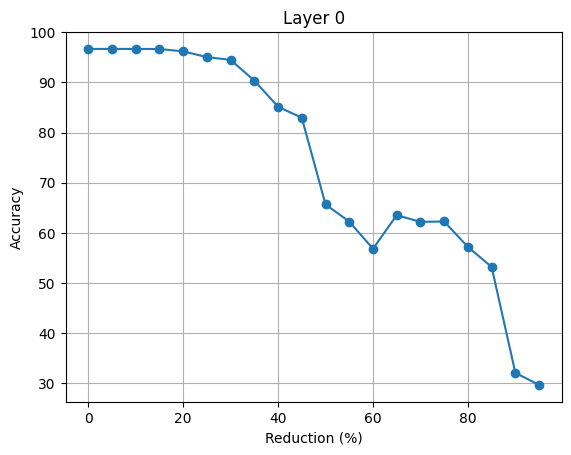

Thresholds: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


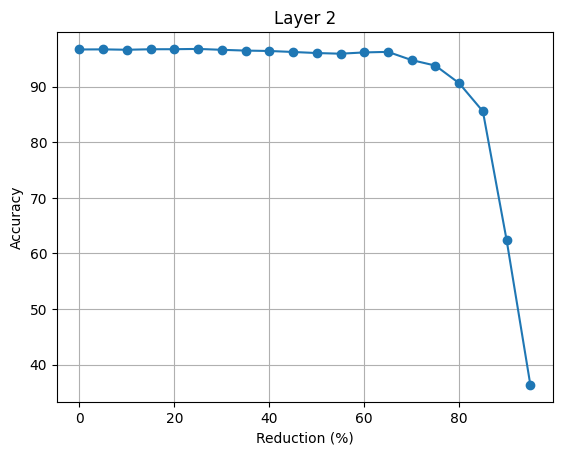

Thresholds: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


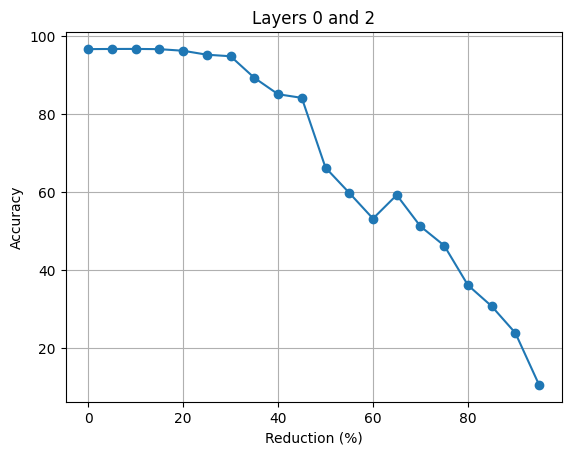

In [180]:
experiment(type_distance='l1')

Thresholds: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


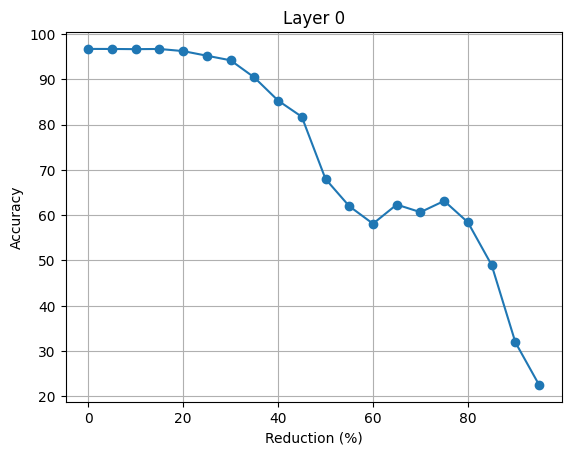

Thresholds: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


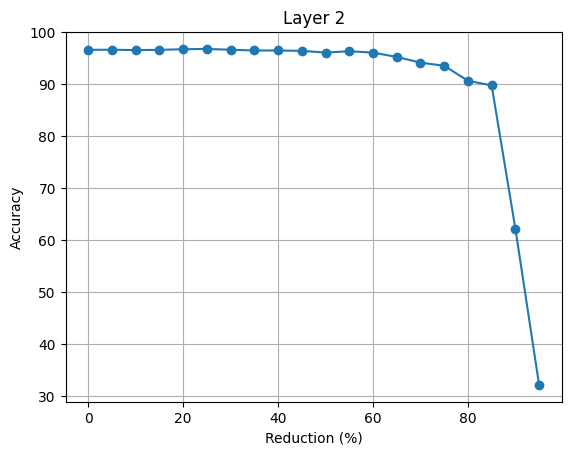

Thresholds: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


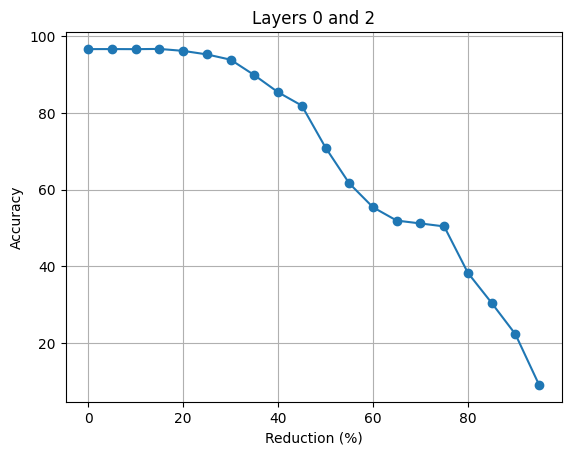

In [181]:
experiment(type_distance='l2')

Thresholds: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


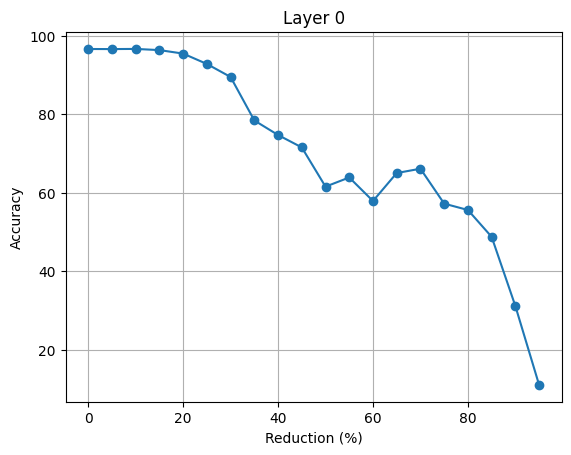

Thresholds: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


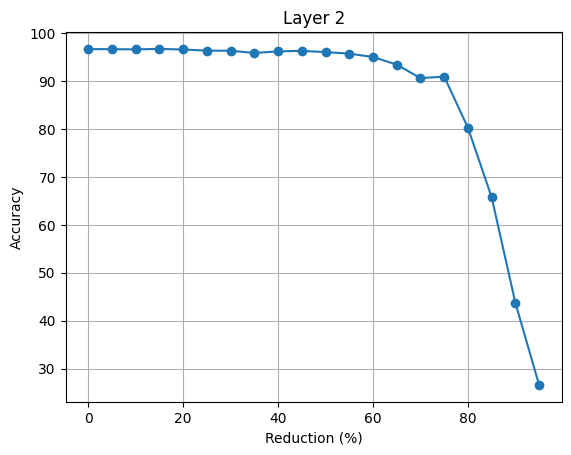

Thresholds: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


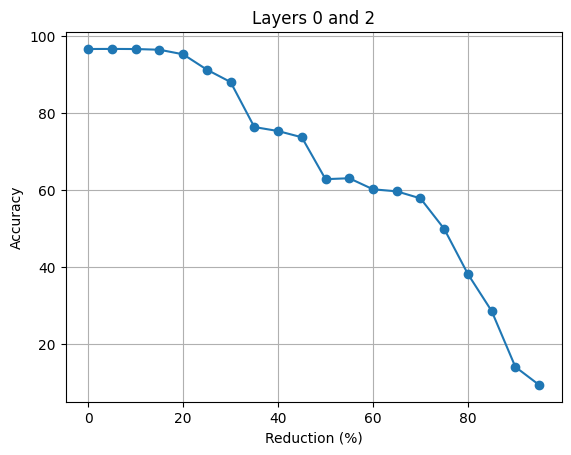

In [182]:
experiment(type_distance='cosine')

In [187]:
def format_number(num: int):
    """Función auxiliar para formatear el número con K, M, B."""
    if num >= 1e9:
        return f"{num / 1e9:.2f}B"
    elif num >= 1e6:
        return f"{num / 1e6:.2f}M"
    elif num >= 1e3:
        return f"{num / 1e3:.2f}K"
    else:
        return str(num)

In [195]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_parameters = format_number(count_parameters(model_pretrained))
print(f'Test accuracy model {total_parameters}: {compute_accuracy(model_pretrained, test_loader, DEVICE):.2f}%')

Test accuracy model 136.07K: 96.72%


In [214]:

m_p = get_model_pruned([0], model=model_pretrained, type_distance='l1', threshold=20, verbose=False)
m_p_2 = get_model_pruned([2], model=m_p, type_distance='l1', threshold=60, verbose=True)
parameters = format_number(count_parameters(m_p_2))

reduction = (1 - count_parameters(m_p_2) / count_parameters(model_pretrained))*100
print(f'Reduction: {reduction:.2f}%')
print(f'Test accuracy pruned model {parameters}: {compute_accuracy(m_p_2, test_loader, DEVICE):.2f}%')

MultilayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=103, bias=True)
    (1): ReLU()
    (2): Linear(in_features=103, out_features=103, bias=True)
    (3): ReLU()
    (4): Linear(in_features=103, out_features=10, bias=True)
  )
)
Reduction: 31.94%
Test accuracy pruned model 92.61K: 95.36%
